In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from cv2 import imread, IMREAD_GRAYSCALE # IMREAD_GRAYSCALE allow you to load the image as gray scale image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa
import math
import gc
import heapq
import pandas as pd
import numpy as np
import os
import gc
import io
import re
import warnings
from sklearn import metrics

2023-12-26 20:31:15.697251: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 20:31:15.728537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 20:31:15.728569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 20:31:15.729459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 20:31:15.735015: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[1], device_type='GPU')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
filename = 'TBNA_train.tfrecords'

raw_dataset = tf.data.TFRecordDataset(filename)

X_train = []
Y_train = []

for raw_record in raw_dataset:

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    sub_y = []
    sub_y.append(1 if example.features.feature['Lung cancer'].float_list.value[0] == 1 else 0)
    sub_y.append(1 if example.features.feature['Sex'].float_list.value[0] == 1 else 0)
    # sub_y.append(1 if example.features.feature['Total location'].float_list.value[0] == 1 else 0)
    nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
    img_np = np.array(nparr).reshape(380, 395, 3)
    # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    # img_np = cv.imdecode(nparr, cv.IMREAD_COLOR)
#     img_np = cv.imdecode(nparr, cv.COLOR_BGR2RGB)
    X_train.append(img_np)
    Y_train.append(sub_y)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

2023-12-26 20:31:17.903845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21690 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6
/tmp/ipykernel_2521856/4041900582.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)


In [5]:
filename = 'TBNA_test.tfrecords'

raw_dataset = tf.data.TFRecordDataset(filename)

X_test = []
Y_test = []

for raw_record in raw_dataset:

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    sub_y = []
    sub_y.append(1 if example.features.feature['Lung cancer'].float_list.value[0] == 1 else 0)
    sub_y.append(1 if example.features.feature['Sex'].float_list.value[0] == 1 else 0)
    # sub_y.append(1 if example.features.feature['Total location'].float_list.value[0] == 1 else 0)
    nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
    img_np = np.array(nparr).reshape(380, 395, 3)
    # img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
    # img_np = cv.imdecode(nparr, cv.IMREAD_COLOR)
#     img_np = cv.imdecode(nparr, cv.COLOR_BGR2RGB)
    X_test.append(img_np)
    Y_test.append(sub_y)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

/tmp/ipykernel_2521856/221394784.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)


In [6]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],3)
Y_train = Y_train.astype(np.float64)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],3)
Y_test = Y_test.astype(np.float64)

In [7]:
from sklearn.model_selection import train_test_split

X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, random_state=777, train_size=0.7)

In [8]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(610, 380, 395, 3)
(912, 380, 395, 3)
(2127, 380, 395, 3)


In [9]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32).shuffle(buffer_size=1024)
# valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(32).shuffle(buffer_size=1024)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32).shuffle(buffer_size=1024)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32).shuffle(buffer_size=1024)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(32).shuffle(buffer_size=1024)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32).shuffle(buffer_size=1024)

In [14]:
# from tensorflow.keras.applications.densenet_121 import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import Input

input_tensor = Input(shape=(380, 395, 3))
base_model = keras.applications.EfficientNetB0(weights='imagenet', input_tensor=input_tensor)
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer — let's say we have 200 classes
predictions = Dense(2, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name = 'auc', multi_label=False)])

21834768/21834768 [==============================] - 2s 0us/step


In [15]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = model.fit(test_dataset, validation_data=valid_dataset, epochs=30, callbacks=[model_checkpoint_callback])
loss, accuracy = model.evaluate(train_dataset)

print(loss, accuracy)

# print(model.summary())

Epoch 1/30


2023-12-26 20:36:51.023364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-26 20:36:53.854563: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe1a82dadc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-26 20:36:53.854589: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1703623013.952970 2522246 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


67/67 [==============================] - 36s 279ms/step - loss: 0.6897 - auc: 0.5211 - val_loss: 0.6858 - val_auc: 0.5622
Epoch 2/30
67/67 [==============================] - 17s 258ms/step - loss: 0.6838 - auc: 0.5256 - val_loss: 0.6797 - val_auc: 0.5628
Epoch 3/30
67/67 [==============================] - 17s 257ms/step - loss: 0.6792 - auc: 0.5265 - val_loss: 0.6750 - val_auc: 0.5632
Epoch 4/30
67/67 [==============================] - 17s 258ms/step - loss: 0.6756 - auc: 0.5271 - val_loss: 0.6713 - val_auc: 0.5637
Epoch 5/30
67/67 [==============================] - 17s 259ms/step - loss: 0.6729 - auc: 0.5368 - val_loss: 0.6685 - val_auc: 0.5656
Epoch 6/30
67/67 [==============================] - 19s 279ms/step - loss: 0.6709 - auc: 0.5335 - val_loss: 0.6663 - val_auc: 0.5628
Epoch 7/30
67/67 [==============================] - 17s 259ms/step - loss: 0.6694 - auc: 0.5296 - val_loss: 0.6646 - val_auc: 0.5640
Epoch 8/30
67/67 [==============================] - 18s 259ms/step - loss: 0.668

In [16]:
loss, accuracy = model.evaluate(train_dataset)
print(loss, accuracy)

20/20 [==============================] - 1s 54ms/step - loss: 0.7309 - auc: 0.8155
0.7308697700500488 0.8155257105827332


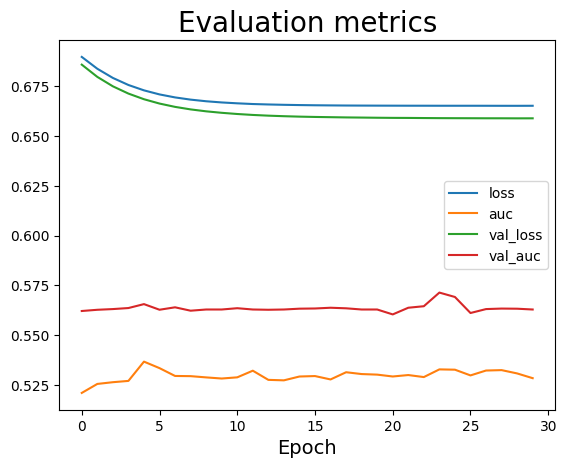

In [17]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['auc'], label="auc")
plt.plot(history.history['val_loss'], label="val_loss")
plt.plot(history.history['val_auc'], label="val_auc")
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

In [18]:
Y_cal = model.predict(X_train)

20/20 [==============================] - 2s 48ms/step


In [19]:
Y_cancer = []
Y_gender = []

for data in Y_train:
    # print(data)
    Y_cancer.append(data[0])
    Y_gender.append(data[1])

Y_cancer = np.array(Y_cancer)
Y_gender = np.array(Y_gender)

In [20]:
Y_cal_cancer = []
Y_cal_gender = []

for data in Y_cal:
    Y_cal_cancer.append(data[0])
    Y_cal_gender.append(data[1])

Y_cal_cancer = np.array(Y_cal_cancer)
Y_cal_gender = np.array(Y_cal_gender)

In [21]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y=TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    
    return optimal_threshold, point

def ROC(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    
    return fpr, tpr, roc_auc, optimal_th, optimal_point

In [22]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score


# fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(Y_train, Y_cal)
# plt.figure(1)
# plt.plot(fpr, tpr, label= f"AUC = {roc_auc:.3f}")
# plt.plot([0, 1], [0, 1], linestyle="--")
# plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
# plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
# plt.title("cancer ROC-AUC")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.show()
# print("optimal_point: ", optimal_point[0], optimal_point[1])
# print("Threshold: ", optimal_th)
# Y = np.around(Y_cal)
# accuracy = accuracy_score(Y_train, Y)
# print('Accuracy: %f' % accuracy)
# precision = precision_score(Y_train, Y)
# print('Precision: %f' % precision)
# recall = recall_score(Y_train, Y)
# print('Recall: %f' % recall)
# f1 = f1_score(Y_train, Y)
# print('F1 score: %f' % f1)

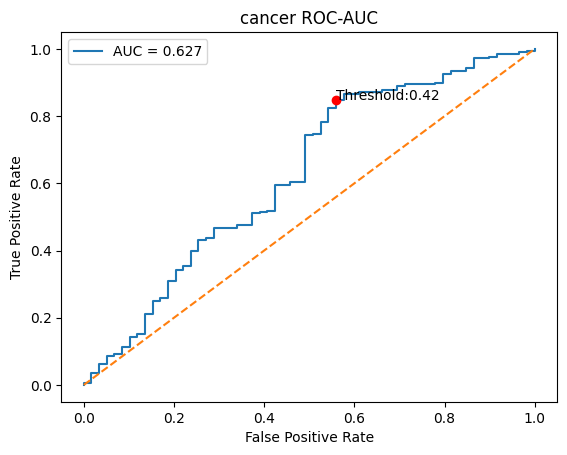

optimal_point:  0.559322033898305 0.8493647912885662
Threshold:  0.4157827
Accuracy: 0.096721
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/home/jupyter-luna11/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(Y_cancer, Y_cal_cancer)
plt.figure(1)
plt.plot(fpr, tpr, label= f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
plt.title("cancer ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print("optimal_point: ", optimal_point[0], optimal_point[1])
print("Threshold: ", optimal_th)
Y = np.around(Y_cal_cancer)
accuracy = accuracy_score(Y_cancer, Y)
print('Accuracy: %f' % accuracy)
precision = precision_score(Y_cancer, Y)
print('Precision: %f' % precision)
recall = recall_score(Y_cancer, Y)
print('Recall: %f' % recall)
f1 = f1_score(Y_cancer, Y)
print('F1 score: %f' % f1)

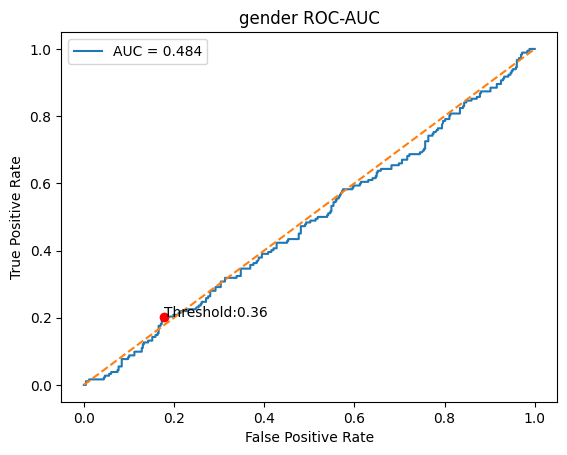

optimal_point:  0.17757009345794392 0.2032967032967033
Threshold:  0.35824496
Accuracy: 0.701639
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000


/home/jupyter-luna11/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(Y_gender, Y_cal_gender)
plt.figure(1)
plt.plot(fpr, tpr, label= f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
plt.title("gender ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
print("optimal_point: ", optimal_point[0], optimal_point[1])
print("Threshold: ", optimal_th)
Y = np.around(Y_cal_gender)
accuracy = accuracy_score(Y_gender, Y)
print('Accuracy: %f' % accuracy)
precision = precision_score(Y_gender, Y)
print('Precision: %f' % precision)
recall = recall_score(Y_gender, Y)
print('Recall: %f' % recall)
f1 = f1_score(Y_gender, Y)
print('F1 score: %f' % f1)

In [26]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(Y_cancer, Y_cal_cancer, average='micro', multi_class='ovr')
print(score)
score = roc_auc_score(Y_cancer, Y_cal_cancer, average='macro', multi_class='ovr')
print(score)

0.6269648405057061
0.6269648405057061


In [27]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(Y_gender, Y_cal_gender, average='micro', multi_class='ovr')
print(score)
score = roc_auc_score(Y_gender, Y_cal_gender, average='macro', multi_class='ovr')
print(score)

0.48353573996097365
0.48353573996097365
